In [2]:
import numpy as np
from numpy.fft import rfft, irfft
import matplotlib.pyplot as mplot
import matplotlib

#from scipy.io.wavfile import read, write
import scipy.io
from scipy import signal
import sounddevice as sd


In [8]:
devices = sd.query_devices()
print(devices)


< 0 Externe Kopfhörer, Core Audio (0 in, 2 out)
> 1 MacBook Pro Mikrofon, Core Audio (1 in, 0 out)
  2 MacBook Pro Lautsprecher, Core Audio (0 in, 2 out)
  3 Soundflower (2ch), Core Audio (2 in, 2 out)
  4 Soundflower (64ch), Core Audio (64 in, 64 out)
  5 ZoomAudioDevice, Core Audio (2 in, 2 out)


## Import Signals

/usr/local/Caskroom/miniconda/base/envs/jupyter_env/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7739: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


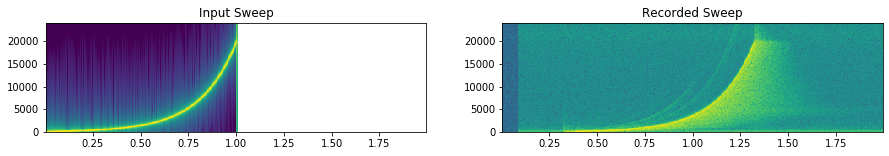

In [4]:
ir_measurement = scipy.io.loadmat('/Users/davidbau/Documents/MATLAB/HRIR Post Processing/Measurements/20-09-02/reference_measurement_02_09.mat')

x = ir_measurement['ref_rawFeedbackLoop'][0, 0, :]
y = ir_measurement['ref_rawRecorded'][0, 0, :]
fs = ir_measurement['fs'][0][0]

# plots
fig, (ax1, ax2) = mplot.subplots(1, 2, figsize=(15, 2))
ax1.set_title('Input Sweep')
ax2.set_title('Recorded Sweep')

_ = ax1.specgram(x, NFFT=512, Fs=fs, noverlap=300, vmin=-200)
_ = ax2.specgram(y, NFFT=512, Fs=fs, noverlap=300, vmin=-200)

In [5]:
sd.play(x, fs)

## Deconvolution

In [3]:
# deconv parameters

# limit dynamic of inverted input magnitude spectrum to prevent intergalactic peaks of inverted notches
max_inv_dyn = 35

# apply lowpass and/or highpass to inverted signal
lowpass = [18000, 4, 2] # fc, order, times applied
highpass = [200, 4, 2]  # fc, order, times applied


## Transform to Frequency Domain

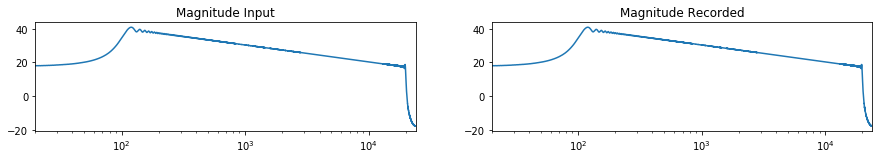

In [4]:
# define length of FFT (zero padding): at least double length of input
input_length = np.size(x)
n = np.ceil(np.log2(input_length)) + 1
N_fft = int(pow(2, n))
N_single_sided = N_fft/2+1

# transform 
# real fft: N real input -> N/2+1 complex output (single sided spectrum)
# real ifft: N/2+1 complex input -> N real output
X_f = rfft(x, N_fft)
Y_f = rfft(x, N_fft)


# plot
f_vec = np.linspace(0, fs/2, N_single_sided)
fig, (ax1, ax2) = mplot.subplots(1, 2, figsize=(15, 2), sharex=True)
ax1.set_title('Magnitude Input')
ax2.set_title('Magnitude Recorded')

ax1.semilogx(f_vec, 20*np.log10(np.abs(X_f)))
ax2.semilogx(f_vec, 20*np.log10(np.abs(Y_f)))
ax1.set_xlim([20, fs/2]);

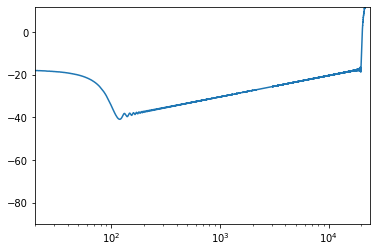

In [6]:
# invert input signal

X_inv = 1 / X_f

#plot
mplot.semilogx(f_vec, 20*np.log10(np.abs(X_inv)))
#mplot.semilogx(np.unwrap(np.angle(X_inv)))

mplot.xlim([20, fs/2]);
mplot.ylim([-90, 12]);

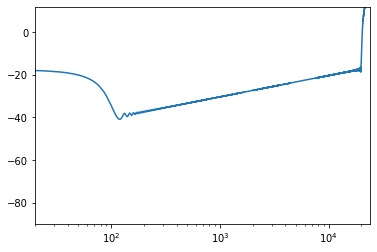

In [7]:
# invert variant 2 (S. Weinzierl: "Generalized multiple sweep measurement", 2009)

X_inv2 = X_f / np.abs(pow(X_f, 2))

#plot
mplot.semilogx(f_vec, 20*np.log10(np.abs(X_inv2)))
#mplot.semilogx(np.unwrap(np.angle(X_inv2)))
mplot.xlim([20, fs/2]);
mplot.ylim([-90, 12]);

## Limit Inversion Dynamic 
Very low magnitude values in the exciation signal (e.g. noise floor when the signal is bandlimited) will result in very large peaks in the inverted signal. To prevent these peaks to affect the deconvolution, they can be limited to a value relative to the lowest magnitude bin value of the inverted signal, thus reducing the dynamic range of the magnitude spectrum.

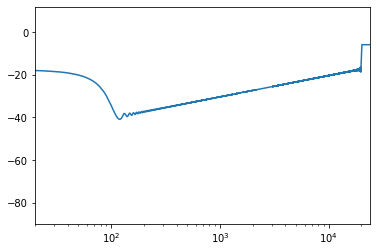

In [8]:
if max_inv_dyn is not None:
    # identify bins that exceed max inversion dynamic
    min_mag = np.min(np.abs(X_inv))
    mag_limit = min_mag * pow(10, np.abs(max_inv_dyn)/20)
    ids_exceed = np.where(abs(X_inv) > mag_limit)
    
    # clip magnitude and leave phase untouched
    X_inv[ids_exceed] = mag_limit * np.exp(1j*np.angle(X_inv[ids_exceed]))
    
#plot
mplot.semilogx(f_vec, 20*np.log10(np.abs(X_inv)))
mplot.xlim([20, fs/2]);
mplot.ylim([-90, 12]);


## Bandlimiting Filters


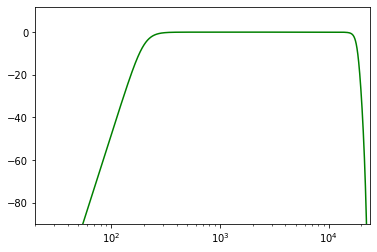

In [9]:
## make fir filter by pushing a dirac through a butterworth SOS (multiple times)

lp_filter = hp_filter = signal.unit_impulse(N_fft)

# lowpass
if lowpass is not None:
    sos_lp = signal.butter(lowpass[1], lowpass[0], 'lowpass', fs=fs, output='sos')
    for i in range(lowpass[2]):
        lp_filter = signal.sosfilt(sos_lp, lp_filter)
lp_filter = rfft(lp_filter)

# highpass
if highpass is not None:
    sos_hp = signal.butter(highpass[1], highpass[0], 'highpass', fs=fs, output='sos')
    for i in range(highpass[2]):
        hp_filter = signal.sosfilt(sos_hp, hp_filter)
hp_filter = rfft(hp_filter)

lp_hp_filter = hp_filter * lp_filter

#plot
mplot.semilogx(f_vec, 20*np.log10(np.abs(lp_hp_filter)), color='green')
mplot.xlim([20, fs/2])
mplot.ylim([-90, 12]);


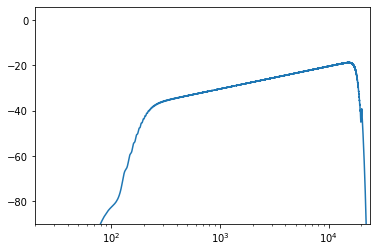

In [10]:
# apply filter
X_inv_filt = X_inv * lp_hp_filter

#plot
mplot.semilogx(f_vec, 20*np.log10(np.abs(X_inv_filt)))
mplot.xlim([20, fs/2])
mplot.ylim([-90, 6]);


Text(0.5, 0, 'Seconds')

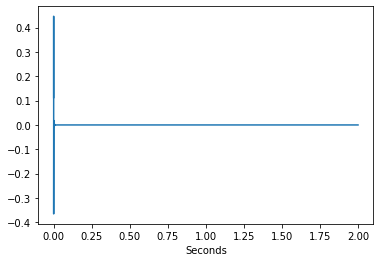

In [11]:
# deconvolve (finally!)
H = Y_f * X_inv_filt

# backward transform
h = irfft(H, N_fft)

# truncate to original length
h = h[:input_length]

t_vec = np.arange(0, np.size(h)) / fs
mplot.plot(t_vec, h)
mplot.xlabel('Seconds')

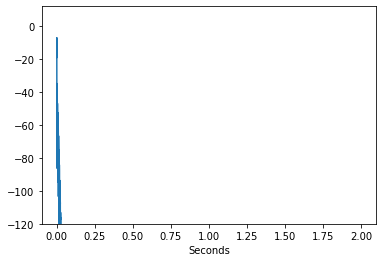

In [12]:
mplot.plot(t_vec, 20*np.log10(np.abs(h)))
mplot.ylim([-120, 12])
mplot.xlabel('Seconds');

# Summary Function
Everything from above squeezed in a single function

In [13]:
def deconvolve(x, y, max_inv_dyn=None, lowpass=[20000, 4, 2], highpass=[50, 4, 2], inversion_variant=False):
    
    input_length = np.size(x)
    n = np.ceil(np.log2(input_length)) + 1
    N_fft = int(pow(2, n))

    # transform
    X_f = rfft(x, N_fft)
    Y_f = rfft(y, N_fft)
    
    # invert input signal
    if inversion_variant:
        X_inv = X_f / np.abs(pow(X_f, 2))
    else:
        X_inv = 1 / X_f
    
    if max_inv_dyn is not None:
        # identify bins that exceed max inversion dynamic
        min_mag = np.min(np.abs(X_inv))
        mag_limit = min_mag * pow(10, np.abs(max_inv_dyn)/20)
        ids_exceed = np.where(abs(X_inv) > mag_limit)

        # clip magnitude and leave phase untouched
        X_inv[ids_exceed] = mag_limit * np.exp(1j*np.angle(X_inv[ids_exceed]))
    
    
    if lowpass is not None or highpass is not None:
        # make fir filter by pushing a dirac through a butterworth SOS (multiple times)
        lp_filter = hp_filter = signal.unit_impulse(N_fft)
        
        # lowpass
        if lowpass is not None:
            sos_lp = signal.butter(lowpass[1], lowpass[0], 'lowpass', fs=fs, output='sos')
            for i in range(lowpass[2]):
                lp_filter = signal.sosfilt(sos_lp, lp_filter)
        lp_filter = rfft(lp_filter)

        # highpass
        if highpass is not None:
            sos_hp = signal.butter(highpass[1], highpass[0], 'highpass', fs=fs, output='sos')
            for i in range(highpass[2]):
                hp_filter = signal.sosfilt(sos_hp, hp_filter)
        hp_filter = rfft(hp_filter)

        lp_hp_filter = hp_filter * lp_filter

        # apply filter
        X_inv = X_inv * lp_hp_filter
    
    # deconvolve (finally!)
    H = Y_f * X_inv

    # backward transform
    h = irfft(H, N_fft)

    # truncate to original length
    h = h[:input_length]
    
    return h

    

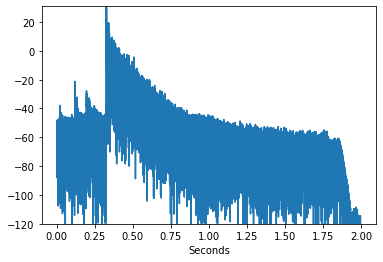

In [56]:
h1 = deconvolve(x, y, max_inv_dyn=None, lowpass=[18000, 4, 2], highpass=[200, 4, 2])
h1 = h1*100
t_vec = np.arange(0, np.size(h1)) / fs
logwaveform = 20*np.log10(np.abs(h1))
mplot.plot(t_vec, logwaveform)
mplot.ylim([-120, np.max([np.max(logwaveform), 12])])
mplot.xlabel('Seconds');